In [139]:
from emg2qwerty.data import EMGSessionData
import os
import nltk
from nltk.corpus import brown # May need to download
from nltk.probability import FreqDist
import collections
import numpy as np
import matplotlib.pyplot as plt 
from scipy.stats import entropy

DATA_ROOT = '/private/home/nmehlman/emg2qwerty/data'

In [58]:
def get_session_text_prompts(session: EMGSessionData) -> list:
    return [prompt['payload']['text'][:-1] for prompt in session.prompts if prompt['name'] == 'text_prompt'] # Remove final '⏎' char

In [82]:
session_files = [os.path.join(DATA_ROOT, f) for f in os.listdir(DATA_ROOT) if f.endswith('.hdf5')]

prompts = []
for file in session_files: # Get all text prompts
    session_data = EMGSessionData(file)
    prompts += get_session_text_prompts(session_data)

In [105]:
baseline_word_priors = FreqDist(brown.words()) # Use brown corpus as 'prior' for word freqeuncy
prompt_word_counts = collections.Counter(word for string in prompts for word in string.split())

# Normalize word counts to get probability
total = prompt_word_counts.total()
prompt_word_freq = {word: count/total for word, count in prompt_word_counts.items()}
prompt_word_freq = {word: prompt_word_freq[word] for word in 
                        sorted(
                                prompt_word_freq.keys(), 
                                key = lambda x: prompt_word_freq[x], 
                                reverse=True) } # Sort word by freqeuncy high to low

prior_word_freq = {word: baseline_word_priors.freq(word) for word in prompt_word_freq}

## Plot freqeuncy of N most common words

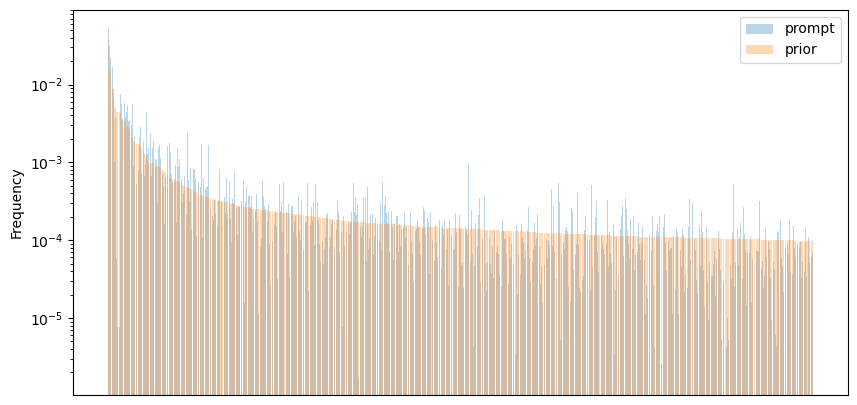

In [127]:
N_PLOT_WORDS = 1000

plt.figure(figsize=(10,5))

words = list(prompt_word_freq.keys())[:N_PLOT_WORDS]
freqs_prior = [prior_word_freq[word] for word in words]
freqs_prompts = [prompt_word_freq[word] for word in words]

#x = words
x = list(range(N_PLOT_WORDS))

plt.bar(x, freqs_prior, log=True, alpha=0.3, label='prompt')
plt.bar(x, freqs_prompts, log=True, alpha=0.3, label='prior')

#plt.gca().set_xticklabels(words, rotation=90)
plt.xticks([])

plt.legend()
plt.ylabel('Frequency')
plt.show()

## Compute KL divergence

In [148]:
p_prompts = np.array(list(prompt_word_freq.values()))
p_prior = np.array(list(prior_word_freq.values()))
p_prior = p_prior/np.sum(p_prior) # Re-normalize

kl_div = entropy(p_prompts[ p_prior>0 ], p_prior[ p_prior>0 ])

print(f'KL divergence: {kl_div:.4e}')


KL divergence: 7.2916e-01
